# Algorithms for Big Data - Exercise 6
This lecture is focused on the basic examples of the RNN usage for time series forecasting.

We will use Amazon stocks dataset from Yahoo finance. You can take look at this [this](https://finance.yahoo.com/quote/AMZN?p=AMZN)

Other datasets are also available, we will show you how to create your own as well.


[Open in Google colab](https://colab.research.google.com/github/rasvob/2020-21-ARD/blob/master/abd_06.ipynb)
[Download from Github](https://github.com/rasvob/2020-21-ARD/blob/master/abd_06.ipynb)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import seaborn as sns
import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.preprocessing import normalize # normalization of the matrix
import scipy
import pandas as pd

tf.version.VERSION

'2.3.0'

In [2]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

In [3]:
class Mish(keras.layers.Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

keras.utils.get_custom_objects().update({'mish': Mish(mish)})

# We have prepared three datasets for your experiments
## AAPL = Apple
## AMZN = Amazon
## SNE = Sony

## You are not limited to them, you can create your own datasets as well
## The prepared data covers period of the last 10 years with daily sampling frequency ~ 2500 values

In [4]:
df = pd.read_csv('./data/SNE.csv')
df.index = pd.to_datetime(df.Date)
df = df.drop('Date', axis=1)

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-10-25,33.689999,34.000000,33.500000,33.560001,30.684494,579800
2010-10-26,33.820000,34.020000,33.630001,33.910000,31.004501,1042800
2010-10-27,33.759998,33.900002,33.389999,33.849998,30.949646,709300
2010-10-28,33.680000,33.970001,33.630001,33.820000,30.922213,1116400
2010-10-29,33.880001,34.259998,33.560001,33.840000,30.940502,1162400


# We are interested only in the Open column, which we will forecast
## We will deal with univariate time series forecasting in this lecture

In [6]:
df = pd.DataFrame({'Price': df.iloc[:, 0]})

# The first step in every analysis task is taking a look at the data

In [7]:
def show_timeseries(df):
    figsize = 20
    plt.figure(figsize=(figsize,figsize/2))
    plt.plot(df.index, df)
    plt.ylabel('Price ($)')
    plt.xlabel('Datetime')

# We can see that the stock price has significant trend and there are short term fluctuations as well

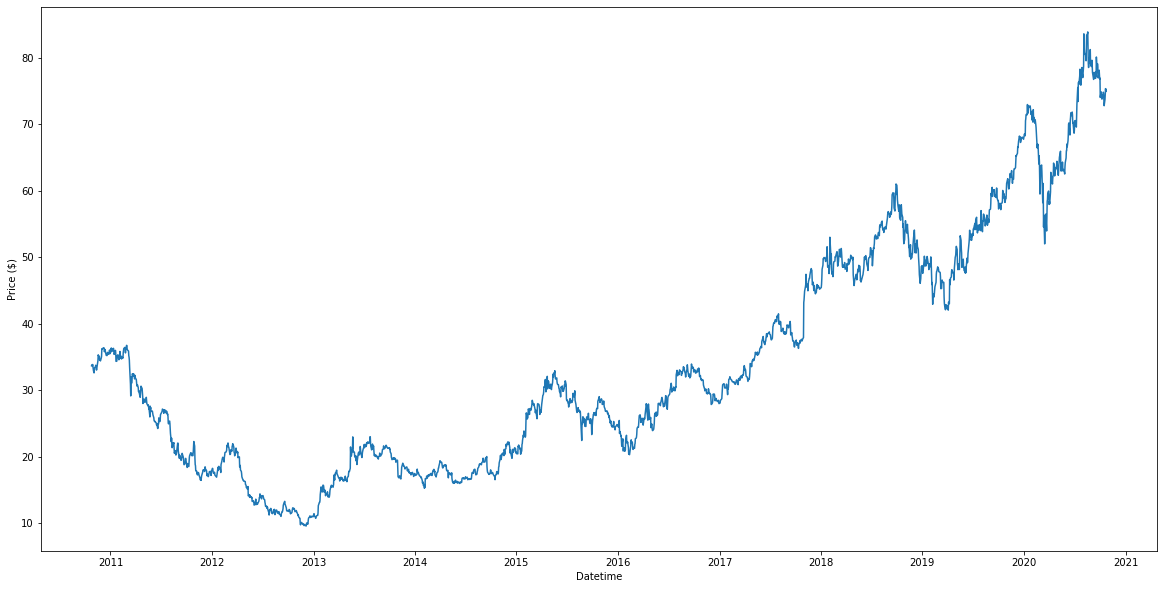

In [8]:
show_timeseries(df)

# Let's take a look at data for the last month
## The changes in the short time periods are not as significant as in the lont term scenario

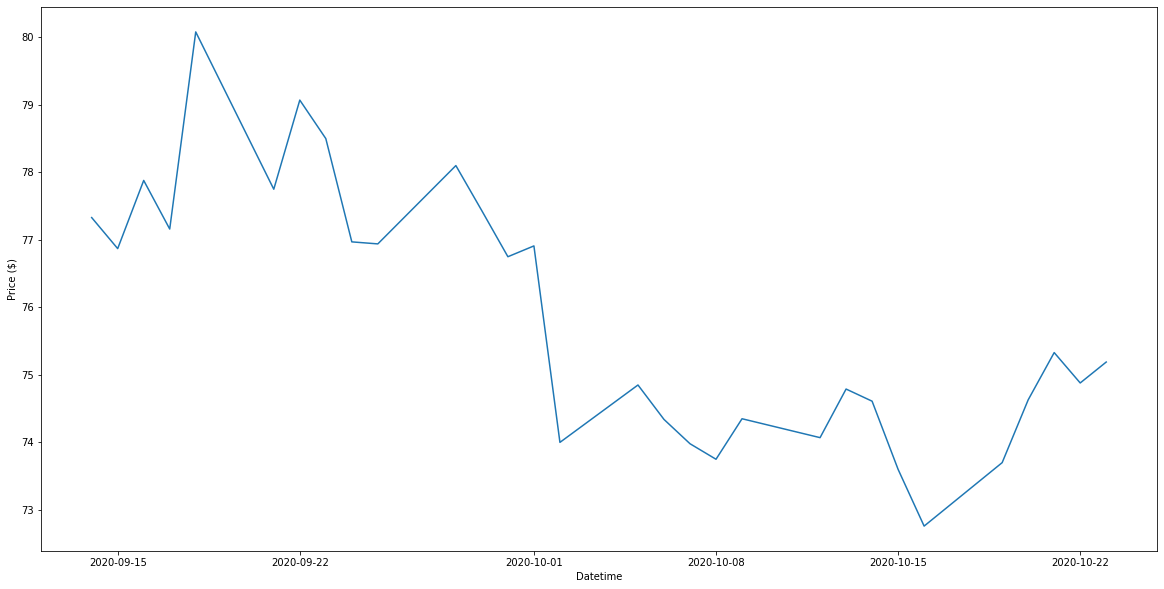

In [9]:
viz_subset = df.iloc[-30:]
show_timeseries(viz_subset)

# We are usually interested in the dependency of the current value on the past values
## Auto-correlation function can help us with it
## We can vizualize the function values as well

(array([-60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48,
        -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35,
        -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22,
        -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,
         -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,
          5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
         18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
         31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
         44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60]),
 array([0.93000765, 0.93116863, 0.93236943, 0.93366946, 0.93494468,
        0.93621812, 0.93747122, 0.93871878, 0.93995178, 0.94117379,
        0.94243644, 0.94374853, 0.94506216, 0.94637524, 0.94764496,
        0.94885083, 0.95004606, 0.95125815, 0.95245205, 0.95368687,
        0.95494319, 0.9561566 , 0.9573556

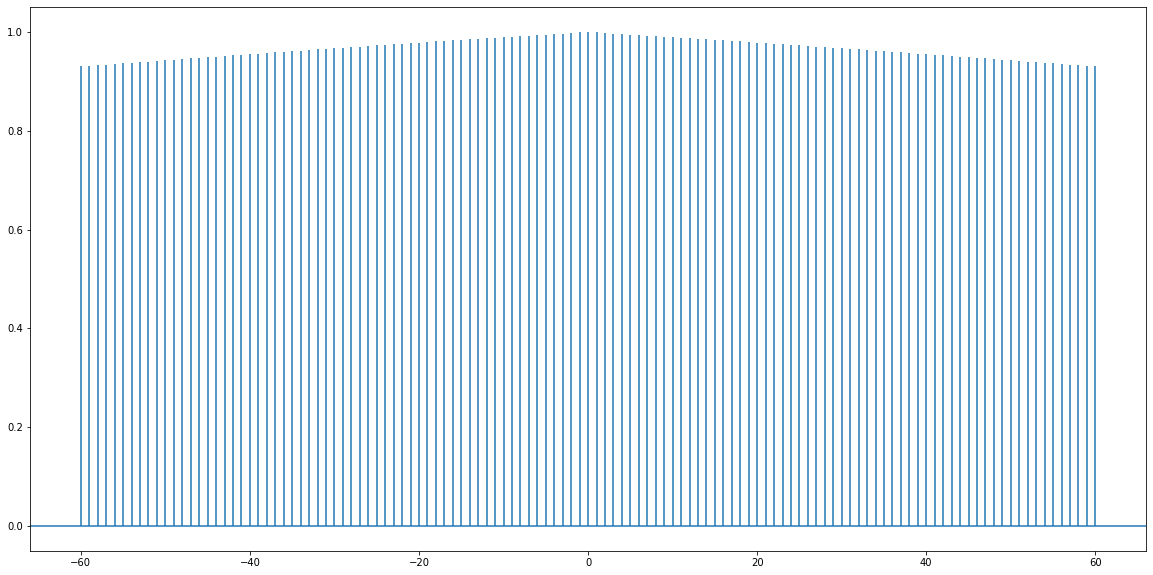

In [10]:
figsize = 20
plt.figure(figsize=(figsize,figsize/2))
plt.acorr(df.Price, maxlags=60)

# The time series has very high auto-correlation function values
## We can see that the ACF values are constantly lower for the longer lag values
## This means that we are mainly interested in the last few weeks/months of the data

# We worked with the classification models in the last few weeks
We evaluated quality of every created models based on its accuracy.

Accuracy is only one of the many metrics for the classification task but it is the simples one (take a look at the F1-Score, AuC/ROC, Precision/recall metrics if you are interested in this area).

Forecasting and regression tasks are not different - we have to evaluate model quality as well, butut now we use different types of metrics - most basic ones are MAE, RMSE which we already encountered.
There are many more metrics - R2, MAPE, sMAPE etc.

We have prepared the evaluation functions API for you.

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

"""
Computes MAPE
"""
def mean_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

"""
Computes SMAPE
"""
def symetric_mean_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(np.abs((y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2.0))) * 100

"""
Computes MAE, MSE, MAPE, SMAPE, R2
"""
def compute_metrics(df: pd.DataFrame) -> pd.DataFrame:
    y_true, y_pred = df['y_true'].values, df['y_pred'].values
    return compute_metrics_raw(y_true, y_pred)

def compute_metrics_raw(y_true: pd.Series, y_pred: pd.Series) -> pd.DataFrame:
    mae, mse, mape, smape, r2 = mean_absolute_error(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred), mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred), symetric_mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred), r2_score(y_true=y_true, y_pred=y_pred)
    return pd.DataFrame.from_records([{'MAE': mae, 'MSE': mse, 'MAPE': mape, 'SMAPE': smape, 'R2': r2}], index=[0])

# The time series data are, surprisingly, time dependant
Time dependency means that we can't for example use Cross-validation or train/valid/test split without minding the time aspect. So to say - we can't split data randomly. We need to use test data from the period after the training set. If we don't take the time into account we will end up with leaking the data from test set to train one. Basically we let the model taking a look into the future. Which is obviously not wanted feature of the model, because there is no magic oracle available in the real-life forecasting scenarios.

# We will use the whole period of 2010 to 2018 as the training dataset
## First half of the 2019 will be used for validation and the second half as the testing dataset
We will drop the 2020 for now.

# Our task will be to forecast the next day stock price

### Our first task is data preprocessing and feature creating - we will use past N values as the model input
#### We can tune this parameter - we will start with 2 months worth of the data

In [12]:
maxlag = 60
df_orig = df.copy()

In [14]:
for x in range(1, maxlag):
    df[f'Price_lag_{x}'] = df.Price.shift(x)

In [15]:
df.head()

,Price,Price_lag_1,Price_lag_2,Price_lag_3,Price_lag_4,Price_lag_5,Price_lag_6,Price_lag_7,Price_lag_8,Price_lag_9,...,Price_lag_50,Price_lag_51,Price_lag_52,Price_lag_53,Price_lag_54,Price_lag_55,Price_lag_56,Price_lag_57,Price_lag_58,Price_lag_59
Date,,,,,,,,,,,,,,,,,,,,,
2010-10-25,33.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-26,33.820000,33.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-27,33.759998,33.820000,33.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-28,33.680000,33.759998,33.820000,33.689999,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-29,33.880001,33.680000,33.759998,33.820000,33.689999,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### We can see that now we have a lot of NaN values - we dont know values of the past prices before dataset start - we will have to drop this rows

# Now we will create the three datasets

In [16]:
X, y = df[df.index < '2020-01-01'].iloc[:, 1:], df[df.index < '2020-01-01'].Price

In [17]:
X_train, y_train = X[X.index.year < 2019], y[X.index.year < 2019]
X_valid, y_valid = X[(X.index.year == 2019) & (X.index.month <= 6)], y[(X.index.year == 2019) & (X.index.month <= 6)]
X_test, y_test = X[(X.index.year == 2019) & (X.index.month > 6)], y[(X.index.year == 2019) & (X.index.month > 6)]

In [18]:
X_train = X_train.dropna()
y_train = y_train[X_train.index]

## The data has to have the same shapes in the first index

In [19]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(2001, 59) (2001,)
(124, 59) (124,)
(128, 59) (128,)


### We can verify the defined intervals for the datasets

In [20]:
X_train.head()

,Price_lag_1,Price_lag_2,Price_lag_3,Price_lag_4,Price_lag_5,Price_lag_6,Price_lag_7,Price_lag_8,Price_lag_9,Price_lag_10,...,Price_lag_50,Price_lag_51,Price_lag_52,Price_lag_53,Price_lag_54,Price_lag_55,Price_lag_56,Price_lag_57,Price_lag_58,Price_lag_59
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-19,35.759998,35.400002,36.049999,36.310001,36.279999,35.930000,36.130001,36.270000,35.810001,36.360001,...,33.41,33.00,32.619999,32.790001,32.930000,33.880001,33.680000,33.759998,33.820000,33.689999
2011-01-20,36.000000,35.759998,35.400002,36.049999,36.310001,36.279999,35.930000,36.130001,36.270000,35.810001,...,33.52,33.41,33.000000,32.619999,32.790001,32.930000,33.880001,33.680000,33.759998,33.820000
2011-01-21,35.619999,36.000000,35.759998,35.400002,36.049999,36.310001,36.279999,35.930000,36.130001,36.270000,...,33.77,33.52,33.410000,33.000000,32.619999,32.790001,32.930000,33.880001,33.680000,33.759998
2011-01-24,34.349998,35.619999,36.000000,35.759998,35.400002,36.049999,36.310001,36.279999,35.930000,36.130001,...,33.59,33.77,33.520000,33.410000,33.000000,32.619999,32.790001,32.930000,33.880001,33.680000
2011-01-25,34.389999,34.349998,35.619999,36.000000,35.759998,35.400002,36.049999,36.310001,36.279999,35.930000,...,33.32,33.59,33.770000,33.520000,33.410000,33.000000,32.619999,32.790001,32.930000,33.880001


In [21]:
print('TRAIN\n', y_train, '\nVALID\n',y_valid, '\nTEST\n',y_test)

TRAIN
 Date
2011-01-19    36.000000
2011-01-20    35.619999
2011-01-21    34.349998
2011-01-24    34.389999
2011-01-25    35.160000
                ...    
2018-12-24    46.070000
2018-12-26    46.779999
2018-12-27    47.599998
2018-12-28    48.610001
2018-12-31    48.730000
Name: Price, Length: 2001, dtype: float64 
VALID
 Date
2019-01-02    47.570000
2019-01-03    48.230000
2019-01-04    48.119999
2019-01-07    49.459999
2019-01-08    50.150002
                ...    
2019-06-24    53.540001
2019-06-25    52.560001
2019-06-26    52.660000
2019-06-27    52.540001
2019-06-28    52.840000
Name: Price, Length: 124, dtype: float64 
TEST
 Date
2019-07-01    53.560001
2019-07-02    53.270000
2019-07-03    54.209999
2019-07-05    54.389999
2019-07-08    54.900002
                ...    
2019-12-24    67.980003
2019-12-26    68.000000
2019-12-27    68.029999
2019-12-30    67.779999
2019-12-31    67.720001
Name: Price, Length: 128, dtype: float64


In [22]:
X_test_idx = X_test.index

# Now we can create the model and evaluate it

### We will start with the simple fully-connected network as baseline

In [23]:
input_layer = keras.layers.Input(shape=X_train.shape[1])
x = keras.layers.Dense(16, activation='relu')(input_layer)
output_layer = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 59)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                960       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mae'])

In [25]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=70, restore_best_weights=True)

batch_size = 32
epochs = 10
history = model.fit(X_train.values, y_train.values, validation_data=(X_valid.values, y_valid.values), callbacks=[es], epochs=epochs, batch_size=batch_size)

Epoch 1/10
63/63 [==============================] - 0s 4ms/step - loss: 624.4999 - mae: 14.6978 - val_loss: 41.9051 - val_mae: 5.4108
Epoch 2/10
63/63 [==============================] - 0s 3ms/step - loss: 23.1182 - mae: 3.9342 - val_loss: 46.6235 - val_mae: 6.0985
Epoch 3/10
63/63 [==============================] - 0s 3ms/step - loss: 21.8915 - mae: 3.8348 - val_loss: 41.0317 - val_mae: 5.7194
Epoch 4/10
63/63 [==============================] - 0s 3ms/step - loss: 20.5283 - mae: 3.7041 - val_loss: 40.7447 - val_mae: 5.6834
Epoch 5/10
63/63 [==============================] - 0s 3ms/step - loss: 19.1835 - mae: 3.5663 - val_loss: 36.9212 - val_mae: 5.3964
Epoch 6/10
63/63 [==============================] - 0s 3ms/step - loss: 17.6949 - mae: 3.4133 - val_loss: 32.1154 - val_mae: 4.6048
Epoch 7/10
63/63 [==============================] - 0s 3ms/step - loss: 17.1718 - mae: 3.3509 - val_loss: 32.2558 - val_mae: 5.0162
Epoch 8/10
63/63 [==============================] - 0s 3ms/step - loss: 15

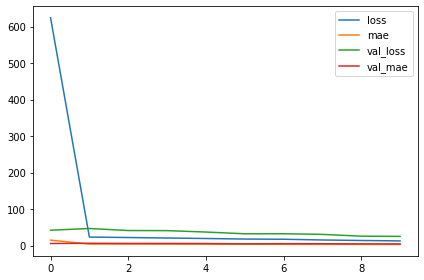

In [26]:
show_history(history)

In [27]:
y_pred = model.predict(X_test.values)

In [28]:
# y_pred_diff = y_pred.reshape(-1) + price_orig[X_test.index].shift(1)

NameError: name 'price_orig' is not defined

In [30]:
df_res = pd.DataFrame({'y_pred': y_pred.reshape(-1), 'y_true': y_test})

In [33]:
df_res

,y_pred,y_true
Date,,
2019-07-01,45.878254,53.560001
2019-07-02,46.353077,53.270000
2019-07-03,47.001686,54.209999
2019-07-05,46.291851,54.389999
2019-07-08,46.263546,54.900002
...,...,...
2019-12-24,60.745544,67.980003
2019-12-26,61.628754,68.000000
2019-12-27,61.475384,68.029999


In [34]:
compute_metrics(df_res)

,MAE,MSE,MAPE,SMAPE,R2
0,3.839162,19.6705,6.416085,6.69365,-0.129543


In [35]:
def show_forecasts(df_res):
    figsize = 20
    plt.figure(figsize=(figsize,figsize/2))
    plt.plot(df_res.index, df_res.y_true, color='red')
    plt.plot(df_res.index, df_res.y_pred, color='green')
    plt.ylabel('Price ($)')
    plt.xlabel('Datetime')

# We can see that the error is quite high but even the relatively simple model captured overlaying trend of the data

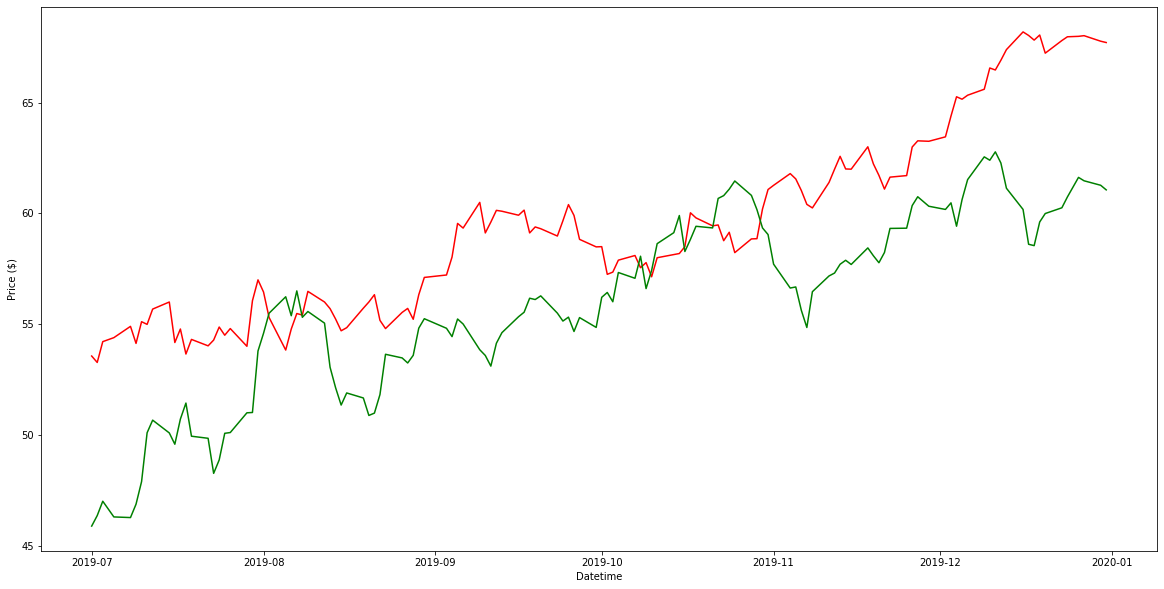

In [36]:
show_forecasts(df_res)

# Now we will try more complex model - recurrent one

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

We can transform the prepared train and test input data into the expected structure using numpy.reshape()

In [37]:
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])
X_valid = X_valid.values.reshape(X_valid.shape[0], 1, X_valid.shape[1])

In [38]:
X_train.shape

(2001, 1, 59)

In [72]:
inp = keras.layers.Input(shape=X_train.shape[1:])
x = keras.layers.LSTM(256, activation='mish', return_sequences=True)(inp)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation='mish')(x)
x = keras.layers.BatchNormalization()(x)
output_layer = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inp, output_layer)
model.summary()
model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mae'])

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1, 59)]           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 256)            323584    
_________________________________________________________________
batch_normalization_13 (Batc (None, 1, 256)            1024      
_________________________________________________________________
dense_14 (Dense)             (None, 1, 256)            65792     
_________________________________________________________________
batch_normalization_14 (Batc (None, 1, 256)            1024      
_________________________________________________________________
dense_15 (Dense)             (None, 1, 1)              257       
Total params: 391,681
Trainable params: 390,657
Non-trainable params: 1,024
___________________________________________

In [73]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=70, restore_best_weights=True)

batch_size = 32
epochs = 50
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[es], epochs=epochs, batch_size=batch_size)

Epoch 1/50
63/63 [==============================] - 1s 13ms/step - loss: 730.8585 - mae: 26.7971 - val_loss: 674.3622 - val_mae: 25.8923
Epoch 2/50
63/63 [==============================] - 1s 9ms/step - loss: 588.3604 - mae: 24.0612 - val_loss: 844.4276 - val_mae: 28.9653
Epoch 3/50
63/63 [==============================] - 1s 8ms/step - loss: 341.7210 - mae: 18.1301 - val_loss: 1887.0702 - val_mae: 43.3949
Epoch 4/50
63/63 [==============================] - 1s 8ms/step - loss: 114.0342 - mae: 10.1143 - val_loss: 207.9454 - val_mae: 14.0209
Epoch 5/50
63/63 [==============================] - 1s 8ms/step - loss: 25.5099 - mae: 4.1719 - val_loss: 12.3580 - val_mae: 2.9129
Epoch 6/50
63/63 [==============================] - 1s 9ms/step - loss: 7.6591 - mae: 2.1229 - val_loss: 28.9189 - val_mae: 5.2491
Epoch 7/50
63/63 [==============================] - 1s 9ms/step - loss: 7.9015 - mae: 2.1916 - val_loss: 164.0228 - val_mae: 12.7360
Epoch 8/50
63/63 [==============================] - 1s 9ms

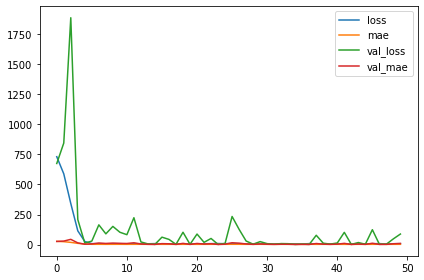

In [74]:
show_history(history)

In [75]:
y_pred = model.predict(X_test)
# y_pred_diff = y_pred.reshape(-1) + price_orig[X_test_idx].shift(1)
df_res = pd.DataFrame({'y_pred': y_pred.reshape(-1), 'y_true': y_test}).dropna()

In [76]:
compute_metrics(df_res)

,MAE,MSE,MAPE,SMAPE,R2
0,9.848627,97.631541,16.660522,15.367423,-4.606317


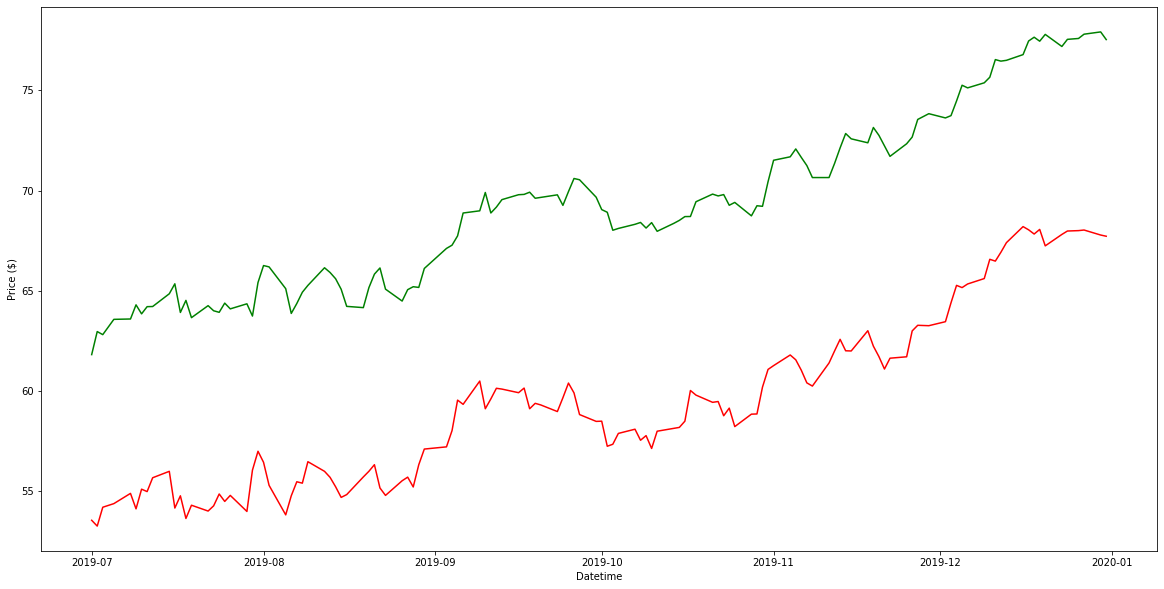

In [77]:
show_forecasts(df_res)

# We can stack multiple LSTM layers on each other

In [94]:
inp = keras.layers.Input(shape=X_train.shape[1:])
x = keras.layers.LSTM(1024, activation='mish', return_sequences=True)(inp)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LSTM(512, activation='mish', return_sequences=True)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation='mish')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation='mish')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inp, output_layer)
model.summary()
model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mae'])

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1, 59)]           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 1, 1024)           4440064   
_________________________________________________________________
batch_normalization_30 (Batc (None, 1, 1024)           4096      
_________________________________________________________________
lstm_20 (LSTM)               (None, 1, 512)            3147776   
_________________________________________________________________
batch_normalization_31 (Batc (None, 1, 512)            2048      
_________________________________________________________________
dense_29 (Dense)             (None, 1, 256)            131328    
_________________________________________________________________
batch_normalization_32 (Batc (None, 1, 256)          

In [95]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=70, restore_best_weights=True)

batch_size = 32
epochs = 50
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[es], epochs=epochs, batch_size=batch_size)

Epoch 1/50
63/63 [==============================] - 1s 22ms/step - loss: 744.6790 - mae: 27.0051 - val_loss: 29.5638 - val_mae: 4.9712
Epoch 2/50
63/63 [==============================] - 1s 14ms/step - loss: 660.5316 - mae: 25.5047 - val_loss: 758.5955 - val_mae: 27.4641
Epoch 3/50
63/63 [==============================] - 1s 15ms/step - loss: 534.0417 - mae: 22.8834 - val_loss: 355.0609 - val_mae: 18.7397
Epoch 4/50
63/63 [==============================] - 1s 15ms/step - loss: 357.0068 - mae: 18.5569 - val_loss: 631.4900 - val_mae: 25.0381
Epoch 5/50
63/63 [==============================] - 1s 14ms/step - loss: 186.4809 - mae: 13.1460 - val_loss: 349.7704 - val_mae: 18.6189
Epoch 6/50
63/63 [==============================] - 1s 15ms/step - loss: 79.2170 - mae: 8.0574 - val_loss: 202.6906 - val_mae: 14.0744
Epoch 7/50
63/63 [==============================] - 1s 14ms/step - loss: 29.5711 - mae: 4.4985 - val_loss: 127.5987 - val_mae: 11.1594
Epoch 8/50
63/63 [=============================

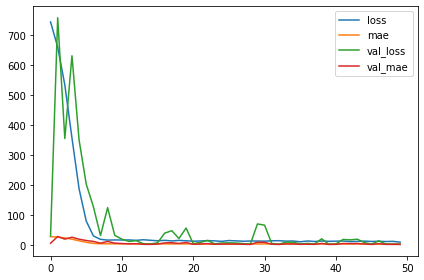

In [96]:
show_history(history)

In [97]:
y_pred = model.predict(X_test)
# y_pred_diff = y_pred.reshape(-1) + price_orig[X_test_idx].shift(1)
df_res = pd.DataFrame({'y_pred': y_pred.reshape(-1), 'y_true': y_test}).dropna()

In [98]:
compute_metrics(df_res)

,MAE,MSE,MAPE,SMAPE,R2
0,1.366842,2.637924,2.251784,2.218702,0.848522


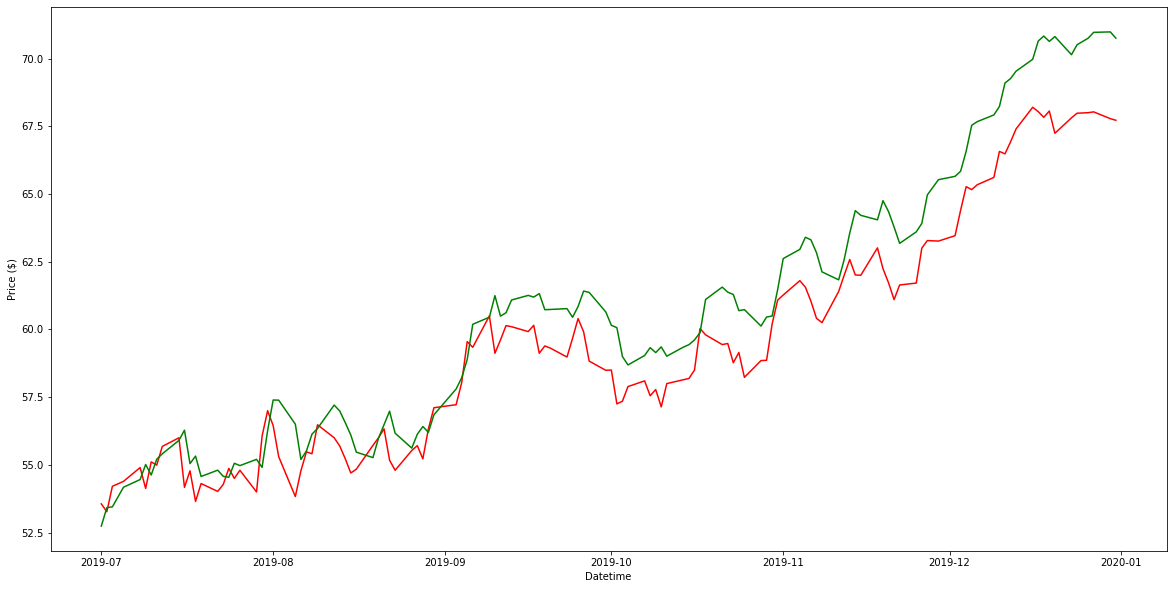

In [99]:
show_forecasts(df_res)

# And we can create really complex models based on LSTM - the situation with LSTM is the same as with every ANN in general - more complex model doesn't mean better solution

In [100]:
inp = keras.layers.Input(shape=X_train.shape[1:])
x = keras.layers.LSTM(1024, activation='mish', return_sequences=True)(inp)
avg1 = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LSTM(256, activation='mish', return_sequences=True)(x)
avg2 = keras.layers.GlobalAveragePooling1D()(x)
concat = keras.layers.Concatenate()([keras.layers.Flatten()(avg1), keras.layers.Flatten()(avg2), keras.layers.Flatten()(x)])
x = keras.layers.Dense(512, activation='mish')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation='mish')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, activation='mish')(x)
output_layer = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inp, output_layer)
model.summary()
model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mae'])

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 1, 59)]           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 1, 1024)           4440064   
_________________________________________________________________
batch_normalization_34 (Batc (None, 1, 1024)           4096      
_________________________________________________________________
lstm_22 (LSTM)               (None, 1, 256)            1311744   
_________________________________________________________________
dense_32 (Dense)             (None, 1, 512)            131584    
_________________________________________________________________
batch_normalization_35 (Batc (None, 1, 512)            2048      
_________________________________________________________________
dense_33 (Dense)             (None, 1, 256)          

In [101]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=70, restore_best_weights=True)

batch_size = 32
epochs = 50
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[es], epochs=epochs, batch_size=batch_size)

Epoch 1/50
63/63 [==============================] - 1s 22ms/step - loss: 178.5804 - mae: 10.6260 - val_loss: 259.3419 - val_mae: 15.9350
Epoch 2/50
63/63 [==============================] - 1s 14ms/step - loss: 21.1728 - mae: 3.5363 - val_loss: 1060.7626 - val_mae: 32.4910
Epoch 3/50
63/63 [==============================] - 1s 13ms/step - loss: 12.7180 - mae: 2.7019 - val_loss: 702.1599 - val_mae: 26.3887
Epoch 4/50
63/63 [==============================] - 1s 13ms/step - loss: 9.3839 - mae: 2.3416 - val_loss: 421.5293 - val_mae: 20.4144
Epoch 5/50
63/63 [==============================] - 1s 14ms/step - loss: 8.1936 - mae: 2.1632 - val_loss: 334.2459 - val_mae: 18.1859
Epoch 6/50
63/63 [==============================] - 1s 15ms/step - loss: 11.8600 - mae: 2.5152 - val_loss: 277.1841 - val_mae: 16.5205
Epoch 7/50
63/63 [==============================] - 1s 14ms/step - loss: 9.2252 - mae: 2.2799 - val_loss: 81.7662 - val_mae: 8.9142
Epoch 8/50
63/63 [==============================] - 1s 14

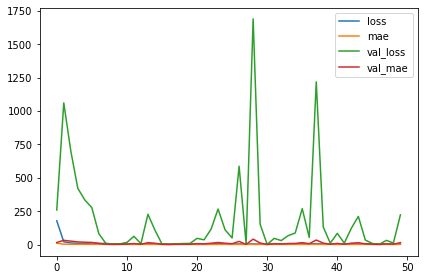

In [102]:
show_history(history)

In [103]:
y_pred = model.predict(X_test)
# y_pred_diff = y_pred.reshape(-1) + price_orig[X_test_idx].shift(1)
df_res = pd.DataFrame({'y_pred': y_pred.reshape(-1), 'y_true': y_test}).dropna()

In [104]:
compute_metrics(df_res)

,MAE,MSE,MAPE,SMAPE,R2
0,15.904134,254.135826,26.835062,31.016184,-13.593296


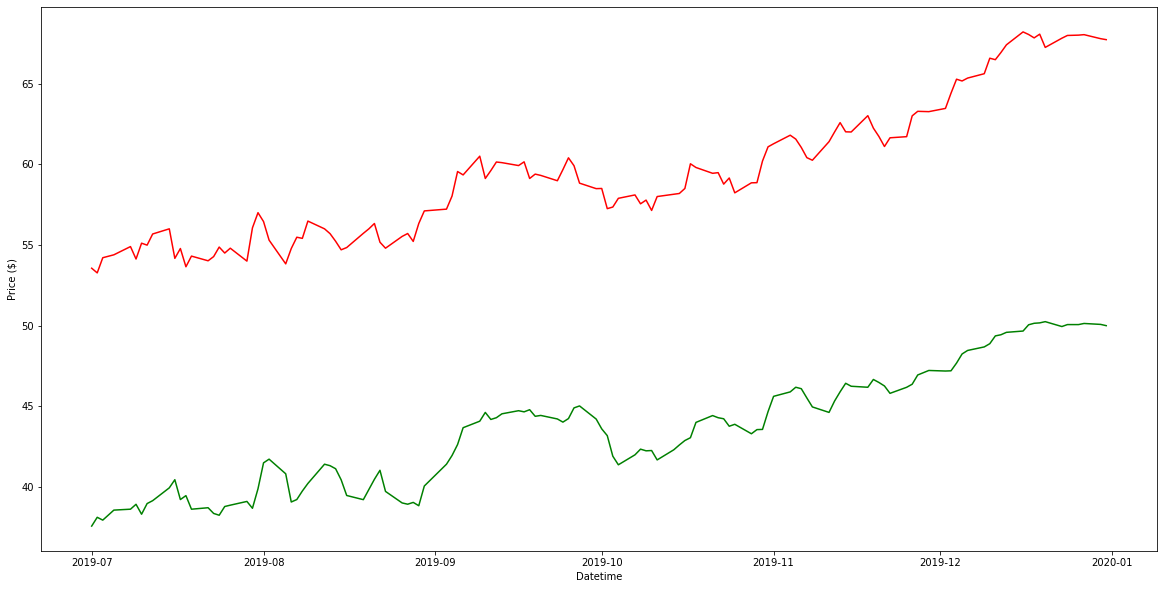

In [105]:
show_forecasts(df_res)

# We can see that the trend extrapolation can be an issue
## What if we could get rid of the trend?
The solution lies in the time series differencing - take a look at [this](https://otexts.com/fpp2/stationarity.html)

## We won't work with the stock price dirrectly but we will use differences between two consecutive values
### Beware the forecast horizon length!
The differencing term can't be shorter than the horizon length, you would create dependency between two forecasts. We have forecast horizon of length 1 - only one day.

In [106]:
maxlag = 60
df_diff = df_orig.copy()
df_diff.Price = df_diff.Price.diff(1)

In [108]:
for x in range(1, maxlag):
    df_diff[f'Price_lag_{x}'] = df_diff.Price.shift(x)

In [109]:
df_diff.head()

,Price,Price_lag_1,Price_lag_2,Price_lag_3,Price_lag_4,Price_lag_5,Price_lag_6,Price_lag_7,Price_lag_8,Price_lag_9,...,Price_lag_50,Price_lag_51,Price_lag_52,Price_lag_53,Price_lag_54,Price_lag_55,Price_lag_56,Price_lag_57,Price_lag_58,Price_lag_59
Date,,,,,,,,,,,,,,,,,,,,,
2010-10-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-26,0.130001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-27,-0.060002,0.130001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-28,-0.079998,-0.060002,0.130001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-29,0.200001,-0.079998,-0.060002,0.130001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


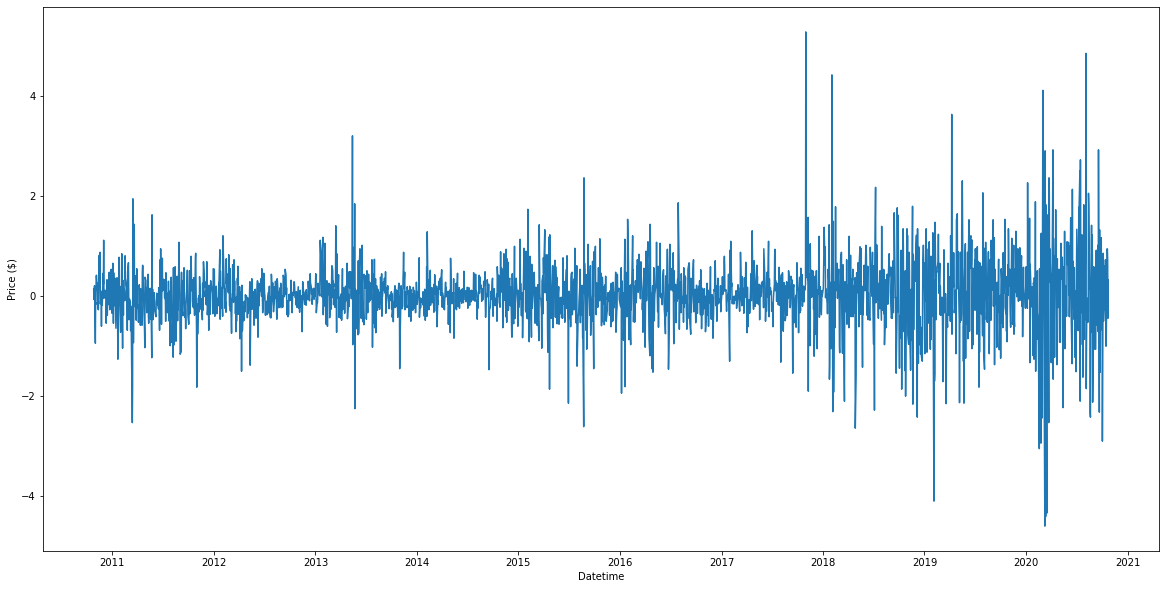

In [114]:
show_timeseries(df_diff.Price)

In [115]:
X, y = df_diff[df.index < '2020-01-01'].iloc[:, 1:], df_diff[df.index < '2020-01-01'].Price

In [116]:
X_train, y_train = X[X.index.year < 2019], y[X.index.year < 2019]
X_valid, y_valid = X[(X.index.year == 2019) & (X.index.month <= 6)], y[(X.index.year == 2019) & (X.index.month <= 6)]
X_test, y_test = X[(X.index.year == 2019) & (X.index.month > 6)], y[(X.index.year == 2019) & (X.index.month > 6)]

In [117]:
X_train = X_train.dropna()
y_train = y_train[X_train.index]

In [118]:
print('TRAIN\n', y_train, '\nVALID\n',y_valid, '\nTEST\n',y_test)

TRAIN
 Date
2011-01-20   -0.380001
2011-01-21   -1.270001
2011-01-24    0.040001
2011-01-25    0.770001
2011-01-26   -0.060002
                ...   
2018-12-24   -1.310001
2018-12-26    0.709999
2018-12-27    0.819999
2018-12-28    1.010003
2018-12-31    0.119999
Name: Price, Length: 2000, dtype: float64 
VALID
 Date
2019-01-02   -1.160000
2019-01-03    0.660000
2019-01-04   -0.110001
2019-01-07    1.340000
2019-01-08    0.690003
                ...   
2019-06-24    0.549999
2019-06-25   -0.980000
2019-06-26    0.099999
2019-06-27   -0.119999
2019-06-28    0.299999
Name: Price, Length: 124, dtype: float64 
TEST
 Date
2019-07-01    0.720001
2019-07-02   -0.290001
2019-07-03    0.939999
2019-07-05    0.180000
2019-07-08    0.510003
                ...   
2019-12-24    0.170005
2019-12-26    0.019997
2019-12-27    0.029999
2019-12-30   -0.250000
2019-12-31   -0.059998
Name: Price, Length: 128, dtype: float64


In [120]:
X_test_idx = X_test.index

In [121]:
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])
X_valid = X_valid.values.reshape(X_valid.shape[0], 1, X_valid.shape[1])

In [122]:
inp = keras.layers.Input(shape=X_train.shape[1:])
x = keras.layers.LSTM(1024, activation='mish', return_sequences=True)(inp)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LSTM(512, activation='mish', return_sequences=True)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation='mish')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation='mish')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inp, output_layer)
model.summary()
model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mae'])

Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 1, 59)]           0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 1, 1024)           4440064   
_________________________________________________________________
batch_normalization_37 (Batc (None, 1, 1024)           4096      
_________________________________________________________________
lstm_25 (LSTM)               (None, 1, 512)            3147776   
_________________________________________________________________
batch_normalization_38 (Batc (None, 1, 512)            2048      
_________________________________________________________________
dense_36 (Dense)             (None, 1, 256)            131328    
_________________________________________________________________
batch_normalization_39 (Batc (None, 1, 256)          

In [123]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=70, restore_best_weights=True)

batch_size = 32
epochs = 50
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[es], epochs=epochs, batch_size=batch_size)

Epoch 1/50
63/63 [==============================] - 1s 21ms/step - loss: 1.8089 - mae: 0.9878 - val_loss: 0.9278 - val_mae: 0.6990
Epoch 2/50
63/63 [==============================] - 1s 14ms/step - loss: 0.8670 - mae: 0.7038 - val_loss: 0.9291 - val_mae: 0.7000
Epoch 3/50
63/63 [==============================] - 1s 15ms/step - loss: 0.6475 - mae: 0.6034 - val_loss: 0.9411 - val_mae: 0.7022
Epoch 4/50
63/63 [==============================] - 1s 15ms/step - loss: 0.5268 - mae: 0.5482 - val_loss: 0.9271 - val_mae: 0.6957
Epoch 5/50
63/63 [==============================] - 1s 14ms/step - loss: 0.4740 - mae: 0.5142 - val_loss: 0.9352 - val_mae: 0.6990
Epoch 6/50
63/63 [==============================] - 1s 14ms/step - loss: 0.3623 - mae: 0.4491 - val_loss: 0.9227 - val_mae: 0.6947
Epoch 7/50
63/63 [==============================] - 1s 14ms/step - loss: 0.3168 - mae: 0.4222 - val_loss: 0.9264 - val_mae: 0.7016
Epoch 8/50
63/63 [==============================] - 1s 14ms/step - loss: 0.2757 - m

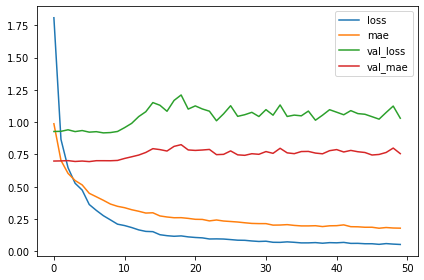

In [124]:
show_history(history)

In [132]:
y_pred = model.predict(X_test)
y_pred_diff = y_pred.reshape(-1) + df_orig.Price[X_test_idx].shift(1)
df_res = pd.DataFrame({'y_pred': y_pred_diff, 'y_true': df_orig.Price[X_test_idx]}).dropna()

# We can see that the LSTM alone is not a silver bullet - good preprocessing still matters even in the ANN area

In [134]:
compute_metrics(df_res)

,MAE,MSE,MAPE,SMAPE,R2
0,0.623128,0.633506,1.070734,1.072354,0.963344


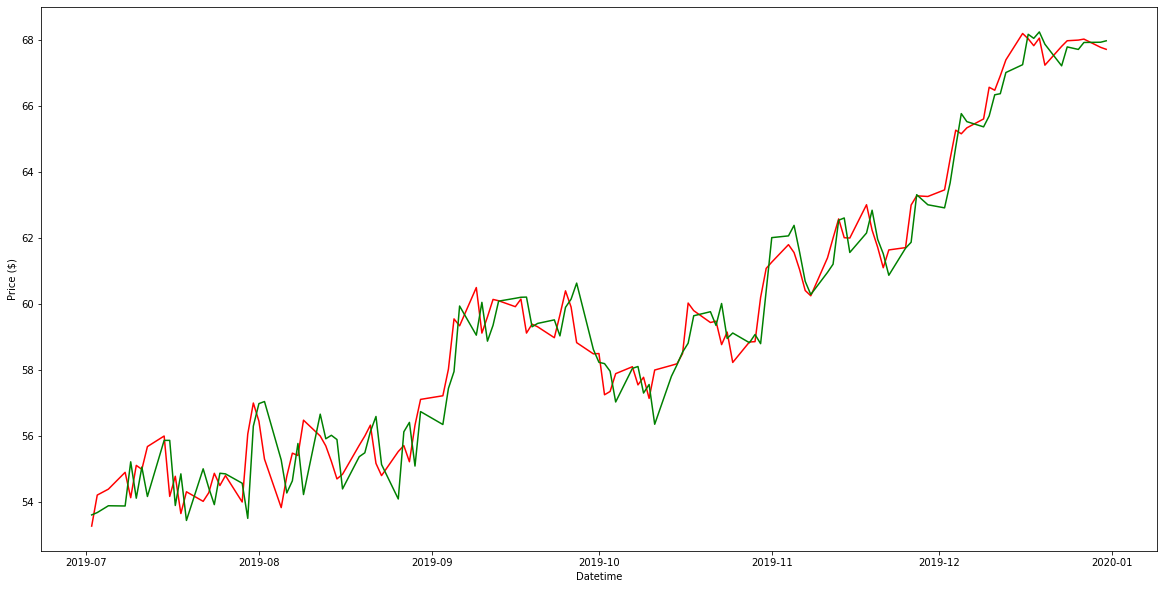

In [135]:
show_forecasts(df_res)

# Task for the lecture

 - Choose other stock prices dataset
 - Try to create your own architecture using reccurent neural networks
 - Experiment a little - try different batch sizes, optimimizers, time lags as features, etc
 - Send me the Cresults with description of your final solution!